In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter
import math
import statistics
import warnings
from sklearn.cluster import SpectralBiclustering
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

In [2]:
def get_frequencies(x):
    for key in x:
        x[key]=x[key]/sum(x.values())
    return x

In [3]:
# model = KMeans(n_clusters=2, init='k-means++')
model = SpectralClustering(n_clusters=2, assign_labels="discretize")

In [4]:
def bisect_numeric_data(dataframe,cluster_labels,corr_mat,thelist,thedict):
    counter=0
    cluster0=[]
    cluster1=[]
    for i in cluster_labels:
        if i==1:
            cluster1.append(counter)
        else:
            cluster0.append(counter)
        counter+=1
    rowData0 = dataframe.loc[ cluster0 , : ]
    rowData1 = dataframe.loc[ cluster1 , : ]
    llist = list( thelist[i] for i in cluster0 )
    rlist = list( thelist[i] for i in cluster1 )
    
    valuelist=list(thedict.values())

    lvallist = list(valuelist[i] for i in cluster0 )
    rvallist = list(valuelist[i] for i in cluster1 )
        
    counter=0
    ldict={}
    rdict={}
    for l in llist:
        ldict[l]=counter
        counter+=1
    counter=0
    for l in rlist:
        rdict[l]=counter
        counter+=1

    mat_left=corr_mat[lvallist,:]
    mat_left=mat_left[:,lvallist]

    mat_right=corr_mat[rvallist,:]
    mat_right=mat_right[:,rvallist]
    
    return rowData0,rowData1, mat_left, mat_right,llist,rlist,ldict,rdict

def bisect_data(dataframe,dataarray,model):
    
    model.fit(dataarray)
    counter=0
    cluster0=[]
    cluster1=[]
    for i in model.labels_:
        if i==1:
            cluster1.append(counter)
        else:
            cluster0.append(counter)
        counter+=1
    rowData0 = dataframe.loc[ cluster0 , : ]
    rowData1 = dataframe.loc[ cluster1 , : ]
    return rowData0,rowData1

def get_data_from_df(dataframe):
    vectordata=[]
    for vec in dataframe.vector:
        if isinstance(vec,float):
            print(type(vec))
            return 0
        svec=sorted(vec.keys())
        arr=[]
        for i in svec:
            arr.append(vec[i]) 
        vectordata.append(arr)
    data=np.array(vectordata)
    return data

def getcorrfortids(flat_df,tid1,tid2):
    l1=list(flat_df[flat_df.tid==tid1].trajectory)
    l2=list(flat_df[flat_df.tid==tid2].trajectory)
# print(l1,l2)
    leng=min(len(l1[0]),len(l2[0]))
    return np.corrcoef(l1[0][:leng],l2[0][:leng])[0, 1]

def get_distance_matrix_from_df(dataframe):
    tidlist=sorted(dataframe.tid)
    tiddict={}
    matrix=np.zeros((len(tidlist), len(tidlist)))
    counter=0
    for tid1 in tidlist:
        tiddict[tid1]=counter
        counter+=1
    for tid1 in tidlist:
        if not(isinstance(tid1,int)):
            print(type(tid1))
        if tiddict[tid1] % 10==0:
            print(tiddict[tid1])
            
        for tid2 in tidlist:
            if not(isinstance(tid2,int)):
                print(type(tid2))
            if tid1<=tid2:
                corr=getcorrfortids(dataframe,tid1,tid2)
            else:
                corr=matrix[tiddict[tid2],tiddict[tid1]]
            matrix[tiddict[tid1],tiddict[tid2]]=corr
    return matrix,tidlist,tiddict

def get_dataframe_from_model(full,model):
    counter=0
    cluster0=[]
    cluster1=[]
    for i in model.labels_:
    #     print(counter,i)
        if i==1:
            cluster1.append(counter)
        else:
            cluster0.append(counter)
        counter+=1
    rowData0 = full.loc[ cluster0 , : ]
    rowData1 = full.loc[ cluster1 , : ]
    return rowData0, rowData1



In [5]:
class Node:
    def __init__(self, dataframe, depth,parent=None):
#         print('creating node',len(dataframe), ' at depth ',depth)
        self.left = None
        self.right = None
        self.dataframe = dataframe
        self.data = get_data_from_df(self.dataframe)
        self.parent = parent
        self.depth=depth
    def splitTree(self, depth):
        if not(isinstance(self.data,int)) and len(self.data)>minClusterSize:
            df_left, df_right=bisect_data(self.dataframe,self.data,model)    
            df_left.reset_index(drop=True, inplace=True)
            df_right.reset_index(drop=True, inplace=True)
            
            if len(self.data)==1:
                print('***',dataarray.shape)
            else:
                depth+=1
                if len(df_left)>0 and len(df_right)>0:
                    self.left=Node(df_left,depth,self)
                    self.left.splitTree(depth)
                    self.right=Node(df_right,depth,self)
                    self.right.splitTree(depth)
                


In [6]:
class NumericNode:
    def __init__(self, dataframe, corr_matrix, tlist,tdict,depth,parent=None):
        self.left = None
        self.right = None
        self.dataframe = dataframe
        self.matrix = corr_matrix
        self.tlist=tlist
        self.tdict=tdict
        self.parent = parent
        self.depth = depth
        self.model = SpectralClustering(2, affinity='precomputed', assign_labels='discretize',random_state=0)
#         AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
        self.model.fit_predict(self.matrix)
#         SpectralClustering(n_clusters=2, affinity="precomputed", assign_labels="discretize")

    def splitTree(self, depth):
        if not(isinstance(self.matrix,int)) and len(self.matrix)>minClusterSize:
            df_left, df_right, mat_left, mat_right,llist,rlist,ldict,rdict=bisect_numeric_data(self.dataframe,self.model.labels_,self.matrix,self.tlist,self.tdict)    
            df_left.reset_index(drop=True, inplace=True)
            df_right.reset_index(drop=True, inplace=True)
            
            if len(self.dataframe)==1:
                print('***',len(self.dataframe))
            else:
                depth+=1
                if len(df_left)>0 and len(df_right)>0:
                    self.left=NumericNode(df_left,mat_left, llist,ldict,depth,self)
                    self.left.splitTree(depth)
                    self.right=NumericNode(df_right,mat_right,rlist,rdict,depth,self)
                    self.right.splitTree(depth)
                


In [7]:
def BST_size(node, nodes = 0, leafs=0, depth=0, maxdepth=0):
    if node is None:
        print ("size -1 (Null value in root)")
    if node is not None:
        nodes += 1
        depth += 1
        if depth>maxdepth:
            maxdepth=depth
        if node.left is None and node.right is None:
            leafs+=1
        else:
            if node.left is not None:
                nodes,leafs,depth,maxdepth=BST_size(node.left, nodes, leafs, depth, maxdepth)
            if node.right is not None:
                nodes,leafs,depth,maxdepth=BST_size(node.right, nodes, leafs, depth, maxdepth)
        depth-=1
    return nodes,leafs, depth, maxdepth


In [8]:
# from google.colab import drive 
# import pandas as pd
# drive.mount('/content/gdrive')
# folder='/content/gdrive/My Drive/projects/00running/master/brazil/muitas_trafos_paper/'

In [9]:
folder = "../../datasets/fsny_193/"
dtypes = {'tid': np.int32, 'time':np.int32, 'day': str, 'poi': str, 'type': str, 'root_type': str, 'price':np.float32, 'rating': np.float32, 'weather': str, 'label': str}
df_full = pd.read_csv(filepath_or_buffer=folder+'foursquare.csv', encoding='latin-1', dtype=dtypes)#, low_memory=False)#, delimiter=',')
df_full.head(2)

,tid,time,day,poi,type,root_type,price,rating,weather,label
0,126,317,Monday,The Lair Of Modern Strange Cowboy,Home (private),Residence,-1.0,-1.0,Clear,6
1,126,1404,Monday,Galaxy Gourmet Deli,Deli / Bodega,Food,1.0,8.2,Clouds,6


In [10]:
def mergedicts(col1,col2):
    return col1.update(col2)
#     print(len(col1),len(col2))
#     print(len(col1.update(col2)))
#     print(type(col1))


def create_unibigram_tree_for_aspect(df,trajid,aspect):
    flat_df = df.groupby(trajid)[aspect].apply(list).reset_index(name='trajectory') 
    flat_df['trajectory']=flat_df['trajectory'].apply(lambda x:str(x))
    flat_df['bitraj']=flat_df.trajectory.apply(lambda x: ["_".join(str(b)) for b in zip(x[:-1], x[1:])])
    flat_df['vector']=flat_df['trajectory'].apply(Counter)    
    flat_df['bivector']=flat_df['bitraj'].apply(Counter)
    aaa=flat_df['vector'].apply(lambda x: get_frequencies(x))
    bbb=flat_df['bivector'].apply(lambda x: get_frequencies(x))
    allkeys = frozenset().union(*flat_df['vector'])
    allbikeys = frozenset().union(*flat_df['bivector'])
    for vec in flat_df['vector']:
        for j in allkeys:
            if j not in vec:
                vec[j]=0
    for vec in flat_df['bivector']:
        for j in allbikeys:
            if j not in vec:
                vec[j]=0
    flat_df['unibivector']=flat_df.apply(lambda x:mergedicts(x.vector,x.bivector), axis=1)
    flat_df2 = flat_df.sample(frac=1, axis=1).reset_index(drop=True)
    root = Node(flat_df2,depth=0)
    root.splitTree(0)
    nodes,leafs,depth,maxdepth=BST_size(root,nodes=0,leafs=0,depth=0,maxdepth=0)
    print('Tree has:',nodes,' nodes and ',leafs, ' leafs. Max depth is:', maxdepth) 
    return root

def create_bigram_tree_for_aspect(df,trajid,aspect):
    flat_df = df.groupby(trajid)[aspect].apply(list).reset_index(name='trajectory') 
    flat_df['bitraj']=flat_df.trajectory.apply(lambda x: [b for b in zip(x[:-1], x[1:])])
    flat_df['bivector']=flat_df['bitraj'].apply(Counter)
    bbb=flat_df['bivector'].apply(lambda x: get_frequencies(x))
    allbikeys = frozenset().union(*flat_df['bivector'])
    for vec in flat_df['bivector']:
        for j in allbikeys:
            if j not in vec:
                vec[j]=0
    flat_df.rename(columns={"bivector": "vector"},inplace=True)
    flat_df2 = flat_df.sample(frac=1, axis=1).reset_index(drop=True)
    root = Node(flat_df2,depth=0)
    root.splitTree(0)
    nodes,leafs,depth,maxdepth=BST_size(root,nodes=0,leafs=0,depth=0,maxdepth=0)
    print('Tree has:',nodes,' nodes and ',leafs, ' leafs. Max depth is:', maxdepth) 
    return root

def create_tree_for_aspect(df,trajid,aspect):
    flat_df = df.groupby(trajid)[aspect].apply(list).reset_index(name='trajectory')
    flat_df['vector']=flat_df['trajectory'].apply(Counter)
    aaa=flat_df['vector'].apply(lambda x: get_frequencies(x))
    allkeys = frozenset().union(*flat_df['vector'])
    for vec in flat_df['vector']:
        for j in allkeys:
            if j not in vec:
                vec[j]=0
    flat_df2 = flat_df.sample(frac=1, axis=1).reset_index(drop=True)
    root = Node(flat_df2,depth=0)
    root.splitTree(0)
    nodes,leafs,depth,maxdepth=BST_size(root,nodes=0,leafs=0,depth=0,maxdepth=0)
    print('Tree has:',nodes,' nodes and ',leafs, ' leafs. Max depth is:', maxdepth) 
    return root


def get_record_depth(node, record, depth = 0):
    if node is None:
        print ("depth -1 (Null value in root)")
    if node is not None:
        if node.dataframe.tid.isin([record]).any():
            depth =node.depth
            if node.left is None and node.right is None:
                return depth
            else:
                if node.left is not None:
                    depthfound=get_record_depth(node.left, record, depth)
                    if depthfound>depth:
                        depth=depthfound
                if node.right is not None:
                    depthfound=get_record_depth(node.right, record, depth)
                    if depthfound>depth:
                        depth=depthfound
            return depth
        else:
            return 0
    return depth


def get_least_common_ancestor_depth(node, record1, record2, depth = 0):
    if node is None:
        print ("depth -1 (Null value in root)")
    if node is not None:
        if node.dataframe.tid.isin([record1]).any() and node.dataframe.tid.isin([record2]).any():
            depth = node.depth
            if node.left is None and node.right is None:
                return depth
            else:
                if node.left is not None:
                    depthfound=get_least_common_ancestor_depth(node.left, record1, record2, depth)
                    if depthfound>depth:
                        depth=depthfound
                if node.right is not None:
                    depthfound=get_least_common_ancestor_depth(node.right, record1, record2, depth)
                    if depthfound>depth:
                        depth=depthfound
            return depth
        else:
            return 0
    return depth

def get_wu_palmer_similarity(root,record1,record2):
    lcs=get_least_common_ancestor_depth(root,record1,record2,depth=0)
    r1=get_record_depth(root,record1,depth=0)
    r2=get_record_depth(root,record2,depth=0)
    return 2*lcs/(r1+r2)

In [11]:
n_users=193  #was 20
minClusterSize=5 #was 2
treeNodes=0
treeDepth=0

In [12]:
def create_dict(dataframe,idcol,attribcol,attrib_type='nominal',treetype='unibi'):
    if attrib_type=='numeric':
        the_tree=create_tree_for_numeric_aspect(dataframe,idcol,attribcol)
    else:
        if treetype=='unibi':
            the_tree=create_unibigram_tree_for_aspect(dataframe,idcol,attribcol)
        elif treetype=='bi':
            the_tree=create_bigram_tree_for_aspect(dataframe,idcol,attribcol)
        else:
            the_tree=create_tree_for_aspect(dataframe,idcol,attribcol)
    
    similarities=calculate_similarities_dict(the_tree)
    return similarities

def create_and_trim_dict(dataframe,idcol,attribcol,threshold,attrib_type='nominal',treetype='unibi'):
    similarities=create_dict(dataframe,idcol,attribcol,attrib_type, treetype)
    count=0
    _sum=0
    for key in similarities:
        count += 1
        _sum += similarities[key]
    meansim=_sum/count
    if threshold:
        meansim=threshold
    highsimilarities={}
    for key in similarities:
        if similarities[key]>=meansim:
            highsimilarities[key]=similarities[key]
    return highsimilarities
def get_all_wu_palmer_similarities(root, nodes = 0, leafs=0, depth=0, maxdepth=0, leafnodes=[]):
    node=root
    if depth==0:
        leafnodes=[]
#         np.ndarray(shape=(len(root.dataframe),len(root.dataframe)), dtype=float)*np.nan
#         similarities=similarities.fill(np.nan)
# def BST_size(node, nodes = 0, leafs=0, depth=0, maxdepth=0):
    if node is None:
        print ("size -1 (Null value in root)")
    if node is not None:
        nodes += 1
        depth += 1
#         print('now at depth ',depth )
        if depth>maxdepth:
            maxdepth=depth
        if node.left is None and node.right is None:
#             print(list(node.dataframe.tid))
            leafs+=1
#             depth-=1
#             print('leaf found at depth ',depth)
            leafnodes.append(node)
#             print(list(node.dataframe.tid))
#             for tid1 in list(node.dataframe.tid):
#                 for tid2 in list(node.dataframe.tid):
#                     similarities[str(tid1)+'_'+str(tid2)]=1
# #                     print(get_wu_palmer_similarity(root,tid1,tid2))
#             print(len(similarities))

        else:
            if node.left is not None:
                nodes,leafs,depth,maxdepth,leafnodes=get_all_wu_palmer_similarities(node.left, nodes, leafs, depth, maxdepth, leafnodes)
            if node.right is not None:
                nodes,leafs,depth,maxdepth,leafnodes=get_all_wu_palmer_similarities(node.right, nodes, leafs, depth, maxdepth, leafnodes)
        depth-=1
    return nodes,leafs, depth, maxdepth, leafnodes
    
#     lcs=get_least_common_ancestor_depth(root,record1,record2,depth=0)
#     r1=get_record_depth(root,record1,depth=0)
#     r2=get_record_depth(root,record2,depth=0)
#     return 2*lcs/(r1+r2)

In [13]:
def calculate_similarities_dict(the_tree):
    _,_,_,_,leafnodes=get_all_wu_palmer_similarities(the_tree)
    similarities={}
    for leaf1 in leafnodes:
        for leaf2 in leafnodes:
            if leaf1==leaf2:
                for tid1 in leaf1.dataframe.tid:
                    for tid2 in leaf1.dataframe.tid:
                        similarities[str(tid1)+' '+str(tid2)]=1
            else:
                anc1=leaf1.parent
                anc2=leaf2.parent
                wp=0
                while anc1!=anc2 and anc1.depth>0:
                    anc1=anc1.parent
                    while anc1!=anc2 and anc2.depth>0:
                        anc2=anc2.parent
                    if anc1.depth>0:
                        anc2=leaf2.parent
                if anc1==anc2:
                    lcs=anc1.depth+1
                    r1=leaf1.depth+1
                    r2=leaf2.depth+1
                    wp=2*lcs/(r1+r2)
                for tid1 in leaf1.dataframe.tid:
                    for tid2 in leaf2.dataframe.tid:
                        similarities[str(tid1)+' '+str(tid2)]=wp
    return similarities

def get_average_similarity(trees,l,r):
    sim=0
    for t in trees:
        sim+=get_wu_palmer_similarity(t,l,r)
    return sim/len(trees)


def get_max_similarity(trees,l,r):
    max=0
    for t in trees:
        sim=get_wu_palmer_similarity(t,l,r)
        if sim>max:
            max=sim
    return max

def mean(someList):
    total = 0
    for a in someList:
        total += float(a)
    mean = total/len(someList)
    return mean
def standDev(someList):
    listMean = mean(someList)
    dev = 0.0
    for i in range(len(someList)):
        dev += (someList[i]-listMean)**2
    dev = dev**(1/2.0)
    return dev
def correlCo(someList1, someList2):
    print(type(someList1))
    # First establish the means and standard deviations for both lists.
    xMean = mean(someList1)
    yMean = mean(someList2)
    xStandDev = standDev(someList1)
    yStandDev = standDev(someList2)
    # r numerator
    rNum = 0.0
    for i in range(len(someList1)):
        rNum += (someList1[i]-xMean)*(someList2[i]-yMean)

    # r denominator
    rDen = xStandDev * yStandDev

    r =  rNum/rDen
    return r

def create_tree_for_numeric_aspect(df,trajid,aspect):
    
    flat_df = df.groupby(trajid)[aspect].apply(list).reset_index(name='trajectory')
    flat_df['trajectory']=flat_df['trajectory'].apply(lambda x: sorted(x))
    corr_matrix,tlist,tdict=get_distance_matrix_from_df(flat_df)
    root = NumericNode(flat_df,corr_matrix,tlist,tdict,depth=0)
    root.splitTree(0)
    nodes,leafs,depth,maxdepth=BST_size(root,nodes=0,leafs=0,depth=0,maxdepth=0)
    print('Tree has:',nodes,' nodes and ',leafs, ' leafs. Max depth is:', maxdepth) 
    return root

In [14]:
df=df_full

In [15]:
df['time_quant_24']=pd.qcut(df['time'], q=24, precision=0)
df['time_equal_24']=pd.cut(df['time'], bins=24, precision=0)

df['root_type_price_combo']=df['root_type']+'_'+df['price'].apply(str)
df['root_type_rating_combo']=df['root_type']+'_'+df['rating'].apply(str)
df['rating_price_combo']=df['rating'].apply(str)+'_'+df['price'].apply(str)
df['rating_price_root_type_combo']=df['rating'].apply(str)+'_'+df['price'].apply(str)+'_'+df['root_type']


df['weather_type_combo']=df['weather']+'_'+df['type']
# # df['timezone']=df['time'].apply(str)+'_'+df['type']
# df['price_day_combo']=df['price'].apply(str)+'_'+df['day']
df['day_type_combo']=df['day']+'_'+df['type']
# df['weather_day_combo']=df['weather']+'_'+df['day']
# df['rating_weather_combo']=df['rating'].apply(str)+'_'+df['weather']

# df['day_time_quant_combo']=df['day']+'_'+df['time_quant_12'].astype('str')
df['day_time_equal_combo']=df['day']+'_'+df['time_equal_24'].astype('str') 

# df['day_time_equal_root_type_combo']=df['day']+'_'+df['time_equal_12'].astype('str') +'_'+df['root_type']


In [16]:
from collections import defaultdict

def mergeDict(dict1, dict2):
    dict3 = {**dict1, **dict2}
    for key, value in dict3.items():
        if key in dict1 and key in dict2:
            dict3[key] = [value , dict1[key]]
    return dict3


def mergeMultiDict(allDicts):
    d={}
    if len(allDicts)==1:
        d=allDicts[0]
    elif len(allDicts)==2:
        d=mergeDict(allDicts[0],allDicts[1])
    else:
        d=mergeDict(allDicts[0],allDicts[1])
        for i in range(2,len(allDicts)):
            print(i,len(d))
            d=mergeDict(d,allDicts[i])
    return d


In [17]:
users=list(df.label.unique()[:n_users])
# print(users)
trajids=df[df['label'].isin(users)].tid.unique()
n_traj=len(trajids)
print(len(trajids))
print(trajids)
X = trajids.reshape(-1, 1)
df=df[df['tid'].isin(trajids)]

3079
[  126   127   128 ... 29559 29560 29563]


In [18]:
X.shape

(3079, 1)

In [19]:
import time
treetimes=[]
# tqu_similarities=calculate_similarities_dict(time_quant_12_tree)
threshold=0.4
# teq_similarities=create_and_trim_dict(df,'tid','time',0.7,'numeric','plain')
start = time.time()
tqu_similarities=create_and_trim_dict(df,'tid','time_quant_24',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'time_quant_24'. Elapsed time: {end-start} sec(s))")
treetimes.append(end-start)
start = time.time()
wtc_similarities=create_and_trim_dict(df,'tid','weather_type_combo',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'weather_type_combo'. Elapsed time: {end-start} sec(s))")
treetimes.append(end-start)
start = time.time()
dtc_similarities=create_and_trim_dict(df,'tid','day_type_combo',threshold,'nominal','unibi')
# dteqc_similarities=create_and_trim_dict(df,'tid','day_time_equal_combo',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'day_type_combo'. Elapsed time: {end-start} sec(s))")
treetimes.append(end-start)
start = time.time()


teq_similarities=create_and_trim_dict(df,'tid','time_equal_24',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'time_equal_24'. Elapsed time: {end-start} sec(s))")
treetimes.append(end-start)
start = time.time()
print('done 4')
w_similarities=create_and_trim_dict(df,'tid','weather',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'weather'. Elapsed time: {end-start} sec(s))")
treetimes.append(end-start)
start = time.time()
pt_similarities=create_and_trim_dict(df,'tid','type',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'type'. Elapsed time: {end-start} sec(s))")
treetimes.append(end-start)
start = time.time()
print('done 6')
prt_similarities=create_and_trim_dict(df,'tid','root_type',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'root_type'. Elapsed time: {end-start} sec(s))")
treetimes.append(end-start)
start = time.time()
d_similarities=create_and_trim_dict(df,'tid','day',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'day'. Elapsed time: {end-start} sec(s))")
print('done 8')
treetimes.append(end-start)
start = time.time()
p_similarities=create_and_trim_dict(df,'tid','price',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'price'. Elapsed time: {end-start} sec(s))")
treetimes.append(end-start)
start = time.time()
r_similarities=create_and_trim_dict(df,'tid','rating',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'rating'. Elapsed time: {end-start} sec(s))")
treetimes.append(end-start)
print('done 10')
start = time.time()
rtpub_similarities=create_and_trim_dict(df,'tid','root_type_price_combo',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'root_type_price_combo'. Elapsed time: {end-start} sec(s))")
treetimes.append(end-start)
start = time.time()
rtrub_similarities=create_and_trim_dict(df,'tid','root_type_rating_combo',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'root_type_rating_combo'. Elapsed time: {end-start} sec(s))")
treetimes.append(end-start)
print('done 12')
start = time.time()
rpub_similarities=create_and_trim_dict(df,'tid','rating_price_combo',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'rating_price_combo'. Elapsed time: {end-start} sec(s))")
treetimes.append(end-start)
start = time.time()
rprtub_similarities=create_and_trim_dict(df,'tid','rating_price_root_type_combo',threshold,'nominal','unibi')
end = time.time()
print(f"Aspect: 'rating_price_root_type_combo'. Elapsed time: {end-start} sec(s))")
print('done 14')
treetimes.append(end-start)
print('Mean Tree time:\t'+str(statistics.mean(treetimes)))




c:\Users\yuri.santos\Anaconda3\envs\mat_tree\lib\site-packages\sklearn\cluster\_spectral.py:658: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Tree has: 1727  nodes and  864  leafs. Max depth is: 15
Aspect: 'time_quant_24'. Elapsed time: 58.793800830841064 sec(s))
Tree has: 1731  nodes and  866  leafs. Max depth is: 15
Aspect: 'weather_type_combo'. Elapsed time: 65.37867903709412 sec(s))
Tree has: 1713  nodes and  857  leafs. Max depth is: 14
Aspect: 'day_type_combo'. Elapsed time: 69.31455850601196 sec(s))
Tree has: 1721  nodes and  861  leafs. Max depth is: 14
Aspect: 'time_equal_24'. Elapsed time: 61.75988268852234 sec(s))
done 4


c:\Users\yuri.santos\Anaconda3\envs\mat_tree\lib\site-packages\sklearn\cluster\_spectral.py:658: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Tree has: 1805  nodes and  903  leafs. Max depth is: 17
Aspect: 'weather'. Elapsed time: 60.170645236968994 sec(s))
Tree has: 1747  nodes and  874  leafs. Max depth is: 16
Aspect: 'type'. Elapsed time: 70.58642387390137 sec(s))
done 6
Tree has: 1715  nodes and  858  leafs. Max depth is: 15
Aspect: 'root_type'. Elapsed time: 57.796751260757446 sec(s))


c:\Users\yuri.santos\Anaconda3\envs\mat_tree\lib\site-packages\sklearn\cluster\_spectral.py:658: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\yuri.santos\Anaconda3\envs\mat_tree\lib\site-packages\sklearn\cluster\_spectral.py:658: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Tree has: 1755  nodes and  878  leafs. Max depth is: 15
Aspect: 'day'. Elapsed time: 57.245014667510986 sec(s))
done 8


c:\Users\yuri.santos\Anaconda3\envs\mat_tree\lib\site-packages\sklearn\cluster\_spectral.py:658: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\yuri.santos\Anaconda3\envs\mat_tree\lib\site-packages\sklearn\cluster\_spectral.py:658: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\yuri.santos\Anaconda3\envs\mat_tree\lib\site-packages\sklearn\cluster\_spectral.py:658: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\yuri.santos\Anaconda3\envs\mat_tree\lib\site-packages\sklearn\cluster\_spectral.py:658: UserWarning: The spectral clustering API has changed. 

Tree has: 1807  nodes and  904  leafs. Max depth is: 18
Aspect: 'price'. Elapsed time: 59.36785316467285 sec(s))
Tree has: 1765  nodes and  883  leafs. Max depth is: 15
Aspect: 'rating'. Elapsed time: 57.75213885307312 sec(s))
done 10
Tree has: 1743  nodes and  872  leafs. Max depth is: 14
Aspect: 'root_type_price_combo'. Elapsed time: 59.24897742271423 sec(s))
Tree has: 1709  nodes and  855  leafs. Max depth is: 15
Aspect: 'root_type_rating_combo'. Elapsed time: 59.49021530151367 sec(s))
done 12


c:\Users\yuri.santos\Anaconda3\envs\mat_tree\lib\site-packages\sklearn\cluster\_spectral.py:658: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Tree has: 1729  nodes and  865  leafs. Max depth is: 15
Aspect: 'rating_price_combo'. Elapsed time: 58.404576539993286 sec(s))
Tree has: 1729  nodes and  865  leafs. Max depth is: 14
Aspect: 'rating_price_root_type_combo'. Elapsed time: 60.76582074165344 sec(s))
done 14
Mean Tree time:	61.14823843751635


In [20]:
start = time.time()
indexes=[tqu_similarities,wtc_similarities,dtc_similarities,teq_similarities, w_similarities, pt_similarities, prt_similarities, 
         d_similarities, p_similarities, r_similarities, rtpub_similarities, rtrub_similarities, rpub_similarities, rprtub_similarities]
end = time.time()
print(end-start)

0.0


In [21]:
mergedindex = defaultdict(list)
i=0 
for d in indexes: # you can list as many input dicts as you want here
    i+=1
    print(i)
    for key, value in d.items():
        mergedindex[key].append(value)
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [22]:
len(mergedindex[0])

0

In [23]:
# import pickle
# with open(folder+'output/merged_trimmed_index_2020_12.bin', 'wb') as fid:
#     # print(fid)
#     pickle.dump(mergedindex, fid)
# with open(folder+'output/merged_index_bigram7+6.bin', 'rb') as fid:
#     # print(fid)
#     mergedindex=pickle.load(fid)
## file = open(folder+'output/merged_trimmed_index_unbigram_11.bin', 'wb')
## pickle.dump(mergedindex, file)
## file = open(folder+'output/merged_index_bigram7+6.bin', 'rb')
## mergedindex = pickle.load(file)

In [24]:
# import pickle
# with open(folder+'output/merged_trimmed_index_2020_12.bin', 'rb') as fid:
# ##     # print(fid)
# ##     pickle.dump(mergedindex, fid)
# ## with open(folder+'output/merged_index_bigram7+6.bin', 'rb') as fid:
# ##     # print(fid)
#     mergedindex=pickle.load(fid)

In [25]:
# mergedindex=mergeMultiDict(indexes[0:3])
len(mergedindex)

306843

In [26]:
variances=[]
for ndar in indexes:
    v=np.var(list(ndar.values()))
    print(v)
    variances.append(v)

0.00419446111263046
0.004550207776230944
0.004296810219087203
0.0045111464600085215
0.007633283895690353
0.004305471593137223
0.0041526606162086265
0.008188602435081842
0.007685445770165102
0.005242229795660497
0.004395471003402577
0.004568480375259141
0.006179683276730398
0.004414497654482355


In [27]:
def get_average_similarity_idx(indexes,l,r):
    sim=0
    for i in indexes:
        sim+=i[str(int(l))+' '+str(int(r))]
    return sim/len(indexes)

def get_max_similarity_idx(indexes,l,r):
    max=0
    for i in indexes:
        sim=i[str(int(l))+' '+str(int(r))]
        if sim>max:
            max=sim
    return max

def get_average_similarity_single_idx(index,l,r):
    sim=0
    sims=index[str(int(l))+' '+str(int(r))]
    return np.mean(sims)

def get_max_similarity_single_idx(index,l,r):
    max=0
    sims=index[str(int(l))+' '+str(int(r))]
    if len(sims)>0:
        return np.max(sims)
    else:
        return 0

def get_count_similarity_single_idx(index,l,r,denom):
    nom=0
    sims=index[str(int(l))+' '+str(int(r))]
    if len(sims)>0:
        return np.sum(sims)/denom
    else:
        return 0

def get_weighted_average_similarity_single_idx(index,l,r):
    sim=0
    sims=index[str(int(l))+' '+str(int(r))]
    for g in range(len(sample_pair)):
        sim+=(sims[g]*variances[g])
    sim/=sum(variances)
    return np.mean(sims)

def sim_idx(x, y):
    if x==y-1 and x%10==0:
        print(x,y)
    return get_average_similarity_idx(indexes,x,y)

def maxsim_idx(x, y):
    if x==y-1 and x%10==0:
        print(x,y)
    return get_max_similarity_idx(indexes,x,y)

def sim_single_idx(x, y):
#     print(x,y)
    if x==y-1 and x%10==0:
        print(x,y)
    return get_average_similarity_single_idx(mergedindex,x,y)

def countsim_single_idx(x, y):
#     print(x,y)
    if x==y-1 and x%10==0:
        print(x,y)
    return get_count_similarity_single_idx(mergedindex,x,y,11)


def wavgsim_single_idx(x, y):
    if x==y-1 and x%10==0:
        print(x,y)
    return get_weighted_average_similarity_single_idx(mergedindex,x,y)

def maxsim_single_idx(x, y):
    if x==y-1 and x%10==0:
        print(x,y)
    return get_max_similarity_single_idx(mergedindex,x,y)


# Your method to calculate distance between two samples
def sim(x, y):
    if x==y-1 and x%10==0:
        print(x,y)
    return get_average_similarity(trees,x,y)

def maxsim(x, y):
    if x==y-1 and x%10==0:
        print(x,y)
    return get_max_similarity(trees,x,y)

# Method to calculate distances between all sample pairs
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances


def load_similarities(filename):
    import csv
    datafile = open(filename, 'r')
    datareader = csv.reader(datafile, delimiter=',')
    data = []
    first=True
    for row in datareader:
        if first:
            first=False
        else:
            data.append(row)
    nparray = np.array(data)
    return nparray

In [28]:
len(df.label.unique())

193

In [29]:
len(X)

3079

In [30]:
start = time.time()
# print("hello")
m=pairwise_distances(X, metric=sim_single_idx,n_jobs=2)
end = time.time()
print(end - start)

c:\Users\yuri.santos\Anaconda3\envs\mat_tree\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yuri.santos\Anaconda3\envs\mat_tree\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yuri.santos\Anaconda3\envs\mat_tree\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[130.] [131.]
[290.] [291.]
[330.] [331.]
[470.] [471.]
[640.] [641.]
[910.] [911.]
[920.] [921.]
[1520.] [1521.]
[1730.] [1731.]
[1820.] [1821.]
[1860.] [1861.]
[1870.] [1871.]
[1930.] [1931.]
[2140.] [2141.]
[2200.] [2201.]
[2220.] [2221.]
[2230.] [2231.]
[2280.] [2281.]
[2290.] [2291.]
[2300.] [2301.]
[2460.] [2461.]
[2480.] [2481.]
[2590.] [2591.]
[2710.] [2711.]
[2730.] [2731.]
[3290.] [3291.]
[3330.] [3331.]
[3870.] [3871.]
[4010.] [4011.]
[4270.] [4271.]
[4600.] [4601.]
[4610.] [4611.]
[4830.] [4831.]
[5070.] [5071.]
[5100.] [5101.]
[5180.] [5181.]
[5190.] [5191.]
[5200.] [5201.]
[5210.] [5211.]
[5220.] [5221.]
[5270.] [5271.]
[5670.] [5671.]
[6640.] [6641.]
[6920.] [6921.]
[7180.] [7181.]
[7190.] [7191.]
[7510.] [7511.]
[7830.] [7831.]
[8210.] [8211.]
[8220.] [8221.]
[8240.] [8241.]
[8250.] [8251.]
[8290.] [8291.]
[8930.] [8931.]
[8940.] [8941.]
[8950.] [8951.]
[8960.] [8961.]
[9010.] [9011.]
[9710.] [9711.]
[9740.] [9741.]
[9820.] [9821.]
[9870.] [9871.]
[9890.] [9891.]
[10030

In [31]:
start = time.time()
# print("hello")
mmax = pairwise_distances(X, metric=maxsim_single_idx,n_jobs=2)
end = time.time()
print(end - start)

[130.] [131.]
[290.] [291.]
[330.] [331.]
[470.] [471.]
[640.] [641.]
[910.] [911.]
[920.] [921.]
[1520.] [1521.]
[1730.] [1731.]
[1820.] [1821.]
[1860.] [1861.]
[1870.] [1871.]
[1930.] [1931.]
[2140.] [2141.]
[2200.] [2201.]
[2220.] [2221.]
[2230.] [2231.]
[2280.] [2281.]
[2290.] [2291.]
[2300.] [2301.]
[2460.] [2461.]
[2480.] [2481.]
[2590.] [2591.]
[2710.] [2711.]
[2730.] [2731.]
[3290.] [3291.]
[3330.] [3331.]
[3870.] [3871.]
[4010.] [4011.]
[4270.] [4271.]
[4600.] [4601.]
[4610.] [4611.]
[4830.] [4831.]
[5070.] [5071.]
[5100.] [5101.]
[5180.] [5181.]
[5190.] [5191.]
[5200.] [5201.]
[5210.] [5211.]
[5220.] [5221.]
[5270.] [5271.]
[5670.] [5671.]
[6640.] [6641.]
[6920.] [6921.]
[7180.] [7181.]
[7190.] [7191.]
[7510.] [7511.]
[7830.] [7831.]
[8210.] [8211.]
[8220.] [8221.]
[8240.] [8241.]
[8250.] [8251.]
[8290.] [8291.]
[8930.] [8931.]
[8940.] [8941.]
[8950.] [8951.]
[8960.] [8961.]
[9010.] [9011.]
[9710.] [9711.]
[9740.] [9741.]
[9820.] [9821.]
[9870.] [9871.]
[9890.] [9891.]
[10030

In [32]:
m2=np.nan_to_num(m)
mmax2=np.nan_to_num(mmax)

In [33]:
# with open(folder+'output/m_2020_12.bin', 'wb') as fid:
#     # print(fid)
#     pickle.dump(m, fid)
# with open(folder+'output/m2_2020_12.bin', 'wb') as fid:
#     # print(fid)
#     pickle.dump(m2, fid)

In [34]:
true_labels=df[df['label'].isin(users)][['tid','label']].drop_duplicates().label

In [35]:
# !pip install trajminer -q

In [36]:
from trajminer.clustering.base import Clustering
from trajminer.similarity.pairwise import pairwise_similarity
class KMedoids2(Clustering):
    """K-Medoids Clustering.
    Parameters
    ----------
    n_clusters : int
        The number of clusters to group trajectories into.
    init : 'park' or array-like (default=None)
        The indices of the trajectories representing the initial cluster
        medoids. If 'park', the medoids will be initialized using the
        approach introduced in [Park et al., 2009] (see references). If
        ``None``, the initial medoids will be chosen randomly.
    seed : int (default=None)
        The random seed to be used for centroid initialization. If ``None``,
        the default seed of NumPy will be used.
    max_iter : int (default=300)
        The maximum number of iterations to run the algorithm, in case it has
        not yet converged.
    measure : SimilarityMeasure object or str (default='precomputed')
        The similarity measure to use for computing similarities (see
        :mod:`trajminer.similarity`) or the string 'precomputed'.
    n_jobs : int (default=1)
        The number of parallel jobs.
    References
    ----------
    `Park, H. S., & Jun, C. H. (2009). A simple and fast algorithm for
    K-medoids clustering. Expert systems with applications, 36(2), 3336-3341.
    <https://www.sciencedirect.com/science/article/pii/S095741740800081X>`__
    """

    def __init__(self, n_clusters, init=None, seed=None, max_iter=300,
                 measure='precomputed', n_jobs=1):
        self.n_clusters = n_clusters
        self.init = init
        self.seed = seed
        self.max_iter = max_iter
        self.measure = measure
        self.n_jobs = n_jobs

    def fit_predict(self, X):
        if self.measure != 'precomputed':
            self.distances = 1 - pairwise_similarity(X=X, measure=self.measure,
                                                     n_jobs=self.n_jobs)
        else:
            self.distances = np.array(X)

        if not self.init:
            if self.seed is not None:
                random.seed(self.seed)

            idxs = np.r_[0:len(self.distances)]
            random.shuffle(idxs)
            self.medoids = idxs[:self.n_clusters]
        elif self.init == 'park':
            scores = np.zeros(len(self.distances))

            for j in range(0, len(self.distances)):
                scores[j] = 0
                for i in range(0, len(self.distances)):
                    scores[j] += self.distances[i][j] / \
                        np.sum(self.distances[i])

            self.medoids = scores.argsort()[0:self.n_clusters]
        else:
            self.medoids = self.init

        self.medoids = np.sort(self.medoids).astype(int)
        clusters = {}

        for self.iter in range(1, self.max_iter + 1):
            new_medoids = np.zeros(self.n_clusters)

            d = self.distances[:, self.medoids].argmin(axis=1)
            clusters = dict(zip(np.r_[0:self.n_clusters],
                                [np.where(d == k)[0]
                                 for k in range(self.n_clusters)]))

            for k in range(self.n_clusters):
                kcluster=clusters[k]
                if len(kcluster)>0:
                    d = self.distances[np.ix_(clusters[k],
                                              clusters[k])].mean(axis=1)
                    j = d.argmin()
                    new_medoids[k] = clusters[k][j]

            new_medoids = np.sort(new_medoids).astype(int)

            if np.array_equal(self.medoids, new_medoids):
                break

            self.medoids = new_medoids.copy()
        else:
            d = self.distances[:, self.medoids].argmin(axis=1)
            clusters = dict(zip(np.r_[0:self.n_clusters],
                                [np.where(d == k)[0]
                                 for k in range(self.n_clusters)]))

        self.labels_ = np.zeros(len(self.distances))

        for key in clusters:
            self.labels_[clusters[key]] = key + 1

        self.labels_ = self.labels_.astype(int)
        return self.labels_

In [37]:
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import f1_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.cluster import OPTICS
from sklearn.cluster import cluster_optics_dbscan 


In [38]:
# import pickle
# file = open('output/avg_sims_'+str(n_users)+'_100_combo_11_trimmed_spectral.bin', 'wb')
# pickle.dump(m, file)
# file = open('output/max_sims_'+str(n_users)+'_100_combo_11_trimmed_spectral.bin', 'wb')
# pickle.dump(mmax, file)
# file = open('output/avg_sims_'+str(n_users)+'_100_combo7_6_spectral.bin', 'rb')
# m2 = pickle.load(file)
# file = open('output/wavg_sims_'+str(n_users)+'_100_combo7_6_spectral.bin', 'rb')
# mwavg2 = pickle.load(file)

In [39]:
# n_traj=len(trajids)
# price_tree=create_tree_for_aspect(df,'tid','price')
# muitas=load_similarities(folder+'datasets/distancematrix_4s_muitas_193.csv')
muitas=load_similarities(folder+'muitas.csv')
msm=load_similarities(folder+'msm.csv')
muitas=muitas[:n_traj,:n_traj]
msm=msm[:n_traj,:n_traj]
print(muitas.shape)
lcss=load_similarities(folder+'lcss.csv')
edr=load_similarities(folder+'edr.csv')

(3079, 3079)


In [40]:
# cluster = AgglomerativeClustering(n_clusters=n_users, affinity='precomputed', linkage='complete')
# cluster = SpectralClustering(n_users, affinity='precomputed', assign_labels='discretize')
# cluster = SpectralClustering(n_users, affinity='precomputed', assign_labels='kmeans')
# cluster = OPTICS(min_samples = 10, xi = 0.5, min_cluster_size = 4,metric="precomputed") 
algos=[
    (AgglomerativeClustering(n_clusters=n_users, affinity='precomputed', linkage='single'),'Agglomerative Single Linkage'),
#     AgglomerativeClustering(n_clusters=n_users, affinity='precomputed', linkage='complete'),
      (AgglomerativeClustering(n_clusters=n_users, affinity='precomputed', linkage='average'),'Agglomerative Average Linkage'),
      (SpectralClustering(n_users, affinity='precomputed', assign_labels='discretize'),'Spectral Clustering'),
        (KMedoids2(n_clusters=n_users, init='park'),'k-Medoids')    
#       SpectralClustering(n_users, affinity='precomputed', assign_labels='kmeans'),
#       SpectralClustering(n_users, affinity='precomputed', assign_labels='discretize', eigen_solver='arpack'),
#       SpectralClustering(n_users, affinity='precomputed', assign_labels='discretize', eigen_solver='arpack', gamma='0.5')
]

In [41]:
muitas2=muitas.astype(np.float)
msm2=msm.astype(np.float)
lcss2=lcss.astype(np.float)
edr2=edr.astype(np.float)

C:\Users\yuri.santos\AppData\Local\Temp\ipykernel_13460\3279844714.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  muitas2=muitas.astype(np.float)
C:\Users\yuri.santos\AppData\Local\Temp\ipykernel_13460\3279844714.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  msm2=msm.astype(np.float)
C:\Users\yuri.santos\AppData\Local\Temp\ipyk

In [42]:
# np.isnan(muitas).any()
import scipy.stats
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#     return m, m-h, m+h
    return m,h

In [43]:
m2.shape
avv = (m2 > 0.6) * m2
# avv = [0 if a_ < 0.5 for a_ in m2]
# avv=(np.array(muitas2) + np.array(m2)) / 2.0
muitas2[0][:50]

array([1.    , 0.605 , 0.5   , 0.515 , 0.4839, 0.5024, 0.5517, 0.6286,
       0.54  , 0.4875, 0.5514, 0.5056, 0.4727, 0.3722, 0.3256, 0.3613,
       0.3152, 0.373 , 0.4063, 0.3724, 0.3484, 0.3933, 0.3862, 0.2667,
       0.2929, 0.3857, 0.4222, 0.3949, 0.4089, 0.3487, 0.4391, 0.4718,
       0.3419, 0.4242, 0.4634, 0.28  , 0.3733, 0.3548, 0.3655, 0.3688,
       0.3548, 0.3353, 0.359 , 0.2645, 0.269 , 0.3737, 0.3533, 0.4049,
       0.3211, 0.331 ])

In [44]:
warnings.filterwarnings('ignore')

measures=[(m2,'Mean TraFoS'),(mmax,'Max TraFoS'),
          # (avv,'W/Thr TraFoS'),
          (muitas2,'MUITAS'),(msm2,'MSM'), (edr2,'EDR'),(lcss2,'LCSS')]
for cluster,algoname in algos:
    print('Clustering Algorithm:\t'+algoname)
#     print('Similarity Measure & Homogeneity & Completeness & V-measure & Mutual Info & Rand'+
#           ' & Fowlkes Mallows & Silhouette Coef. & Calinski Harabasz & Davies Bouldin \\\\ \hline\hline')
    print('Sim. Meas. & Homogen. & Complet. & V-measure & Mut. Info & Rand & F.M. & Silhouette & C.H. & D.B.\\\\ \hline\hline')
    for sim_matrix,measurename in measures:
#         print(type(sim_matrix))
#     print(sim_matrix.shape)
#         print("fitting done")
        homo_=[]
        comple_=[]
        vmeas_=[]
        muinfo_=[]
        rand_=[]
        fowl_=[]
        silh_=[]
        cali_=[]
        dabo_=[]
        for exp in range(0,5):
            cluster.fit_predict(sim_matrix)
            (homo,comple,vmeas)=homogeneity_completeness_v_measure(true_labels,cluster.labels_)
            muinfo=adjusted_mutual_info_score(true_labels,cluster.labels_)
            rand=adjusted_rand_score(true_labels,cluster.labels_)
            fowl=fowlkes_mallows_score(true_labels,cluster.labels_)
            silh=silhouette_score(sim_matrix,cluster.labels_)#,metric='precomputed')#
            cali=calinski_harabasz_score(sim_matrix,cluster.labels_)
            dabo=davies_bouldin_score(sim_matrix,cluster.labels_)
#             print('%.4f'%(homo)+'\t'+'%.4f'%(comple))
            homo_.append(homo)
            comple_.append(comple)
            vmeas_.append(vmeas)
            muinfo_.append(vmeas)
            rand_.append(rand)
            fowl_.append(fowl)
            silh_.append(silh)#
            cali_.append(cali)
            dabo_.append(dabo)
#         print('%.4f'%(statistics.mean(homo_))+'\t'+'%.4f'%(statistics.mean(comple_))+'\t'+'%.4f'%(statistics.mean(vmeas_))
#               +'\t'+'%.4f'%(statistics.mean(muinfo_))+'\t'+'%.4f'%(statistics.mean(rand_))+'\t'+'%.4f'%(statistics.mean(fowl_))
#               +'\t'+'%.4f'%(statistics.mean(silh_))+'\t'+'%.4f'%(statistics.mean(cali_))+'\t'+'%.4f'%(statistics.mean(dabo_)))
#         print(measurename+'\t%.2f'%(mean_confidence_interval(homo_)[0])+u'\u00B1'+'%.2f'%(mean_confidence_interval(homo_)[1])+'\t'
#              +'%.2f'%(mean_confidence_interval(comple_)[0])+u'\u00B1'+'%.2f'%(mean_confidence_interval(comple_)[1])+'\t'
#              +'%.2f'%(mean_confidence_interval(vmeas_)[0])+u'\u00B1'+'%.2f'%(mean_confidence_interval(vmeas_)[1])+'\t'
#              +'%.2f'%(mean_confidence_interval(muinfo_)[0])+u'\u00B1'+'%.2f'%(mean_confidence_interval(muinfo_)[1])+'\t'
#              +'%.2f'%(mean_confidence_interval(rand_)[0])+u'\u00B1'+'%.2f'%(mean_confidence_interval(rand_)[1])+'\t'
#              +'%.2f'%(mean_confidence_interval(fowl_)[0])+u'\u00B1'+'%.2f'%(mean_confidence_interval(fowl_)[1])+'\t'
#              +'%.2f'%(mean_confidence_interval(silh_)[0])+u'\u00B1'+'%.2f'%(mean_confidence_interval(silh_)[1])+'\t'
#              +'%.2f'%(mean_confidence_interval(cali_)[0])+u'\u00B1'+'%.2f'%(mean_confidence_interval(cali_)[1])+'\t'
#              +'%.2f'%(mean_confidence_interval(dabo_)[0])+u'\u00B1'+'%.2f'%(mean_confidence_interval(dabo_)[1]))


        print(measurename+' & '+'\t%.2f'%(mean_confidence_interval(homo_)[0])+'$\pm$'+'%.2f'%(mean_confidence_interval(homo_)[1])+' & '
             +'%.2f'%(mean_confidence_interval(comple_)[0])+'$\pm$'+'%.2f'%(mean_confidence_interval(comple_)[1])+' & '
             +'%.2f'%(mean_confidence_interval(vmeas_)[0])+'$\pm$'+'%.2f'%(mean_confidence_interval(vmeas_)[1])+' & '
             +'%.2f'%(mean_confidence_interval(muinfo_)[0])+'$\pm$'+'%.2f'%(mean_confidence_interval(muinfo_)[1])+' & '
             +'%.2f'%(mean_confidence_interval(rand_)[0])+'$\pm$'+'%.2f'%(mean_confidence_interval(rand_)[1])+' & '
             +'%.2f'%(mean_confidence_interval(fowl_)[0])+'$\pm$'+'%.2f'%(mean_confidence_interval(fowl_)[1])+' & '
             +'%.2f'%(mean_confidence_interval(silh_)[0])+'$\pm$'+'%.2f'%(mean_confidence_interval(silh_)[1])+' & '
             +'%.2f'%(mean_confidence_interval(cali_)[0])+'$\pm$'+'%.2f'%(mean_confidence_interval(cali_)[1])+' & '
             +'%.2f'%(mean_confidence_interval(dabo_)[0])+'$\pm$'+'%.2f'%(mean_confidence_interval(dabo_)[1])+'\\\\ \hline')
    print('-----------------------')

Clustering Algorithm:	Agglomerative Single Linkage
Sim. Meas. & Homogen. & Complet. & V-measure & Mut. Info & Rand & F.M. & Silhouette & C.H. & D.B.\\ \hline\hline
Mean TraFoS & 	0.08$\pm$0.00 & 0.72$\pm$0.00 & 0.14$\pm$0.00 & 0.14$\pm$0.00 & 0.00$\pm$0.00 & 0.08$\pm$0.00 & -0.11$\pm$0.00 & 0.98$\pm$0.00 & 1.02$\pm$0.00\\ \hline
Max TraFoS & 	0.08$\pm$0.00 & 0.72$\pm$0.00 & 0.14$\pm$0.00 & 0.14$\pm$0.00 & 0.00$\pm$0.00 & 0.08$\pm$0.00 & -0.11$\pm$0.00 & 0.99$\pm$0.00 & 1.01$\pm$0.00\\ \hline
MUITAS & 	0.06$\pm$0.00 & 0.58$\pm$0.00 & 0.11$\pm$0.00 & 0.11$\pm$0.00 & 0.00$\pm$0.00 & 0.07$\pm$0.00 & -0.37$\pm$0.00 & 0.73$\pm$0.00 & 1.18$\pm$0.00\\ \hline
MSM & 	0.06$\pm$0.00 & 0.58$\pm$0.00 & 0.11$\pm$0.00 & 0.11$\pm$0.00 & -0.00$\pm$0.00 & 0.07$\pm$0.00 & -0.40$\pm$0.00 & 0.70$\pm$0.00 & 1.22$\pm$0.00\\ \hline
EDR & 	0.08$\pm$0.00 & 0.72$\pm$0.00 & 0.14$\pm$0.00 & 0.14$\pm$0.00 & 0.00$\pm$0.00 & 0.08$\pm$0.00 & -0.01$\pm$0.00 & 0.99$\pm$0.00 & 1.00$\pm$0.00\\ \hline
LCSS & 	0.08$\pm$0.00 

In [45]:
for sim_matrix in [m2,mmax2,avv,muitas2]:
    v=np.var(sim_matrix)
    print(v)


0.02679466063999599
0.02693439999546303
0.026772349624648507
0.004309182580170739


In [46]:
aglo=AgglomerativeClustering(n_clusters=n_users, affinity='precomputed', linkage='average')
aglo.fit_predict(sim_matrix)
# print(aglo.labels_[0:500])
# print(aglo.labels_[500:1000])
# print(aglo.labels_[1000:1500])
# print(aglo.labels_[1500:2000])
# print(aglo.labels_[2000:3000])
# print(aglo.labels_[3000:3079])


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [47]:
len(aglo.labels_)

3079

In [48]:
from sklearn.metrics import adjusted_rand_score

In [51]:
warnings.filterwarnings('ignore')
all=[]
measures=[(m,'TraFoS'),
          # (m2,'Mean TraFoS'),
          # (mmax,'Max TraFoS'),
          # (avv,'W/Thr TraFoS'),
          (muitas2,'MUITAS'),(msm2,'MSM'), (edr2,'EDR'),(lcss2,'LCSS')]
for cluster,algoname in algos[0:2]:
  all_labels={}
  print('Clustering Algorithm:\t'+algoname)
  for sim_matrix,measurename in measures:
      sim_matrix = np.nan_to_num(sim_matrix, copy=True, nan=0.0, posinf=None, neginf=None)
      cluster.fit_predict(sim_matrix)
      all_labels[measurename]=cluster.labels_
  print('-----------------------')
  all.append(all_labels)

Clustering Algorithm:	Agglomerative Single Linkage
-----------------------
Clustering Algorithm:	Agglomerative Average Linkage
-----------------------


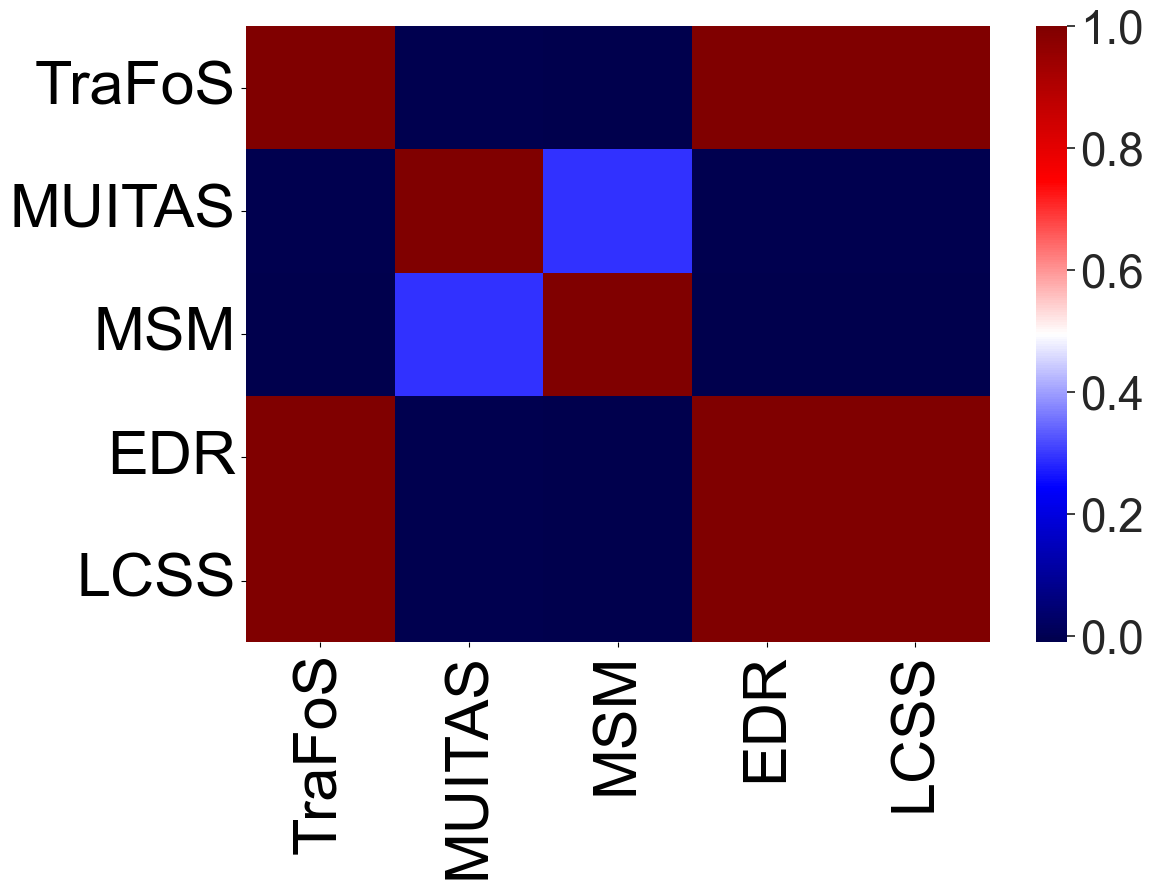

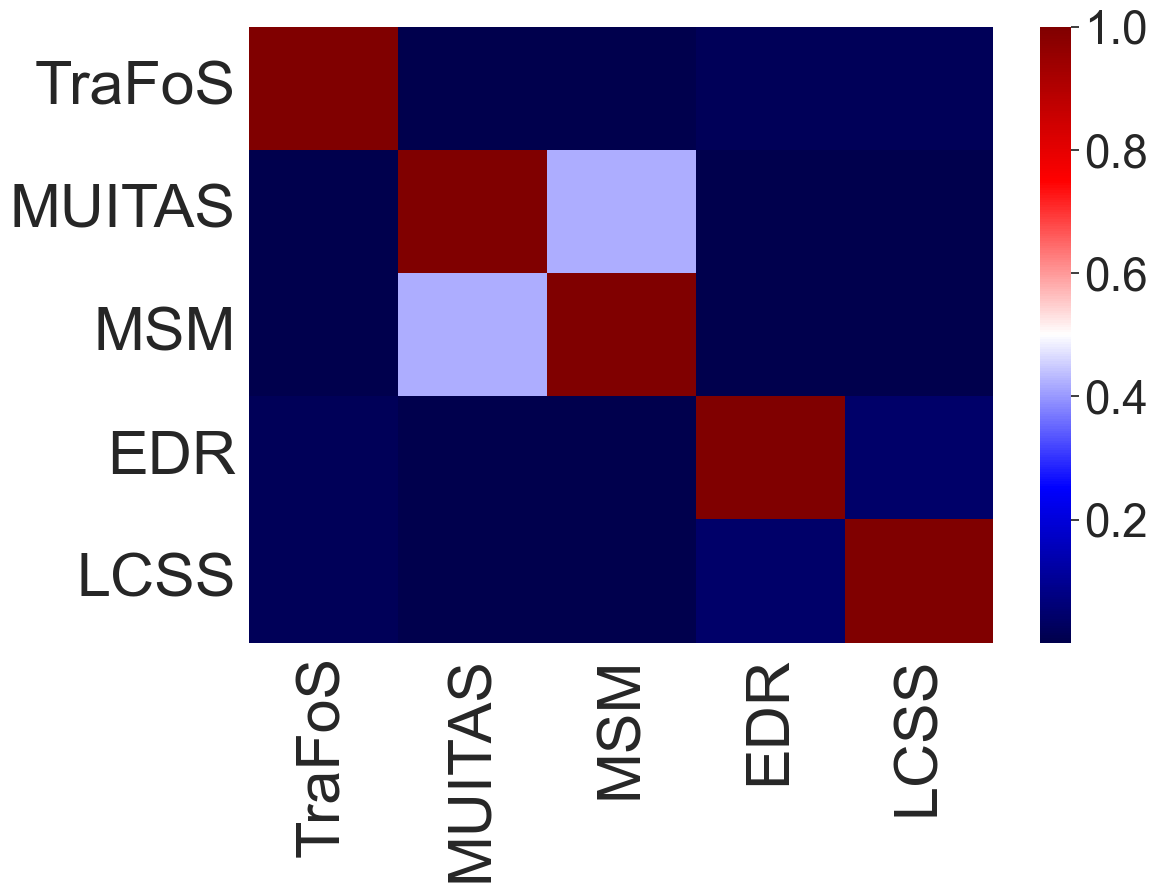

In [52]:
import seaborn as sns
from matplotlib import pyplot

for all_labels in all:
  matrix=np.ndarray((len(all_labels),len(all_labels)))
  i=0
  for labelA in all_labels:
    j=0
    for labelB in all_labels:
      rand=adjusted_rand_score(all_labels[labelA],all_labels[labelB])
      # print(labelA, labelB, rand)
      matrix[i][j]=rand
      j=j+1
    i=i+1
  # print(matrix)
  fig, ax = pyplot.subplots(figsize=(12, 8))
  for tick in ax.xaxis.get_major_ticks():
      tick.label.set_fontsize(44) 
  for tick in ax.yaxis.get_major_ticks():
      tick.label.set_fontsize(44) 
  for tick in ax.figure.axes[-1].yaxis.get_major_ticks():
    # print(tick.label)
    tick.label.set_fontsize(44) 
  sns.set(font_scale=3)
  ax = sns.heatmap(matrix, xticklabels=all_labels.keys(), yticklabels=all_labels.keys(),cmap="seismic")
